In [1]:
!python -m spacy download en

vínculo simbólico creado para C:\Users\USER\.conda\envs\Data Science\lib\site-packages\spacy\data\en <<===>> C:\Users\USER\.conda\envs\Data Science\lib\site-packages\en_core_web_sm
[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[+] Linking successful
C:\Users\USER\.conda\envs\Data Science\lib\site-packages\en_core_web_sm -->
C:\Users\USER\.conda\envs\Data Science\lib\site-packages\spacy\data\en
You can now load the model via spacy.load('en')


In [27]:
import re
def DB_clean(text):
    
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text) 
    text = re.sub(r'https?:/\/\S+', ' ', text) 
    
    return text.strip()

In [1]:
from pandas import read_csv
DATABASE=read_csv('DATABASE_FAKE_NEWS.csv',error_bad_lines=False,encoding='ISO-8859-1')
DATABASE.head()

,FakeOrTrue,Title
0,FAKE,Donald Trump Sends Out Embarrassing New Year...
1,FAKE,Drunk Bragging Trump Staffer Started Russian ...
2,FAKE,Sheriff David Clarke Becomes An Internet Joke...
3,FAKE,Trump Is So Obsessed He Even Has Obama??s Na...
4,FAKE,Pope Francis Just Called Out Donald Trump Dur...


In [2]:
import spacy

In [3]:
DATABASE.shape

(44955, 2)

In [5]:
DATABASE['FakeOrTrue'].unique()

array(['FAKE', 'TRUE'], dtype=object)

In [7]:
DATABASE.FakeOrTrue.value_counts()

FAKE    23538
TRUE    21417
Name: FakeOrTrue, dtype: int64

In [8]:
from matplotlib.pyplot import figure
from seaborn import barplot

[Text(0.5,0,'Labels')]

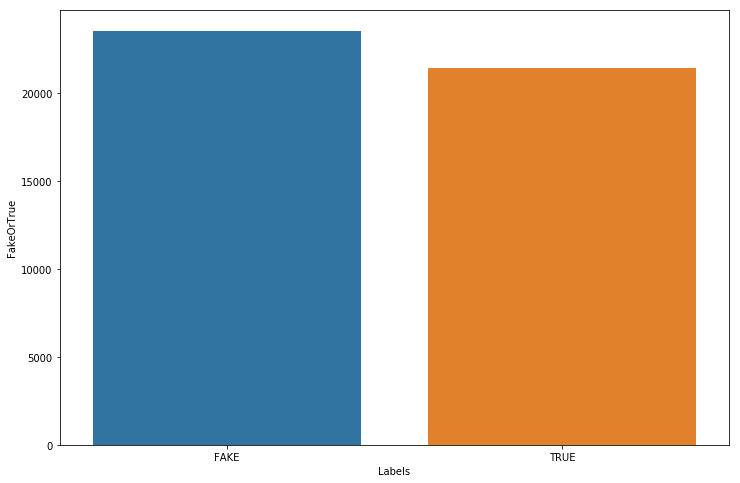

In [10]:
fig= figure(figsize=(12,8))
ax=barplot(x=DATABASE.FakeOrTrue.unique(),y=DATABASE.FakeOrTrue.value_counts())
ax.set(xlabel='Labels')

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
train,test=train_test_split(DATABASE,test_size=0.2,random_state=42)

In [22]:
train.reset_index(drop=True),test.reset_index(drop=True)
print('')

In [23]:
train.head()

,FakeOrTrue,Title
709,FAKE,Maxine Waters Reveals The REAL Reason Pence I...
35343,TRUE,South Korean inbound travel agency says China ...
30749,TRUE,"Trump shuffles transition team, eyes loyalists..."
33999,TRUE,Republican candidate Trump reverses stance on ...
5098,FAKE,New Study PROVES It??s Republicans Who Are T...


In [24]:
train.shape,test.shape

((35964, 2), (8991, 2))

In [25]:
train.to_csv('FakeNewsTrain.csv', index=False)
test.to_csv('FakeNewsTest.csv', index=False)

In [28]:
nlp = spacy.load('en', disable=['parser', 'tagger', 'ner'])
print(nlp)
def tokenizer(s): 
    return [w.text.lower() for w in nlp(DB_clean(s))]

In [34]:
import torch
import torchtext
from torchtext import datasets

In [35]:
TEXT = torchtext.data.Field(tokenize = tokenizer)

LABEL = torchtext.data.LabelField(dtype = torch.float)

In [50]:
datafields = [('FakeOrTrue', LABEL), ('NewsText', TEXT)]
trn, tst = torchtext.data.TabularDataset.splits(path = 'C:/Users/USER/Documents/NLP/Team4NLP'
                                                ,train = 'FakeNewsTrain.csv',
                                                test = 'FakeNewsTest.csv',    
                                                format = 'csv',
                                                skip_header = True,
                                                fields = datafields)


In [51]:
print(f'Number of training examples: {len(trn)}')
print(f'Number of testing examples: {len(tst)}')

Number of training examples: 35964
Number of testing examples: 8991


In [52]:
print(vars(trn.examples[0]))
print(vars(tst.examples[0]))

{'FakeOrTrue': 'FAKE', 'NewsText': ['maxine', 'waters', 'reveals', 'the', 'real', 'reason', 'pence', 'is', 'putting', 'up', 'with', 'trump', 's', 'madness']}
{'FakeOrTrue': 'TRUE', 'NewsText': ['trump', 's', 'about', 'face', 'on', 'fund', 'raising', 'seems', 'unlikely', 'to', 'dent', 'his', 'popularity']}


In [53]:
TEXT.build_vocab(trn, max_size=25000,
                 vectors="glove.6B.100d",
                 unk_init=torch.Tensor.normal_)

LABEL.build_vocab(trn)

.vector_cache\glove.6B.zip: 862MB [25:01, 574kB/s]                                 
100%|█████████▉| 399934/400000 [01:50<00:00, 4398.31it/s]

In [54]:
train_iterator, test_iterator = torchtext.data.BucketIterator.splits(
                                (trn, tst),
                                batch_size = 64,
                                sort_key=lambda x: len(x.NewsText),
                                sort_within_batch=False)

In [82]:
import torch.nn as nn

class RNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, 
                 output_dim, n_layers, bidirectional, dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers = n_layers, 
                           bidirectional = bidirectional, dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        
        self.dropout = nn.Dropout(dropout)

        
    def forward(self, text):
        
        embedded = self.dropout(self.embedding(text))
        
        output, hidden = self.rnn(embedded)
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
       
        return self.fc(hidden.squeeze(0))
    
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.NewsText).squeeze(1)
        
        loss = criterion(predictions, batch.FakeOrTrue)
        
        rounded_preds = torch.round(torch.sigmoid(predictions))
        correct = (rounded_preds == batch.FakeOrTrue).float() 
        
        acc = correct.sum() / len(correct)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [83]:
input_dim = len(TEXT.vocab)

embedding_dim = 100

hidden_dim = 30
output_dim = 1

n_layers = 2
bidirectional = True

dropout = 0.5

In [84]:
model = RNN(input_dim, 
            embedding_dim, 
            hidden_dim, 
            output_dim, 
            n_layers, 
            bidirectional, 
            dropout)

In [85]:
model

RNN(
  (embedding): Embedding(19675, 100)
  (rnn): GRU(100, 30, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=60, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [86]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([19675, 100])


In [87]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 6.3807e-01,  9.6683e-01, -1.2646e+00,  ..., -1.0882e+00,
          1.6259e-02,  2.2180e+00],
        [-2.5074e+00, -6.2984e-01, -1.7067e+00,  ...,  1.1893e+00,
         -6.8992e-01,  8.5701e-02],
        [-1.8970e-01,  5.0024e-02,  1.9084e-01,  ..., -3.9804e-01,
          4.7647e-01, -1.5983e-01],
        ...,
        [-1.4709e+00,  1.3334e+00,  1.2202e+00,  ...,  1.5256e-01,
          2.2435e-01, -6.7753e-01],
        [ 8.2777e-02, -7.1753e-01,  6.7851e-01,  ..., -3.0470e-01,
         -7.3071e-02, -4.0593e-01],
        [ 5.2880e-01, -9.7414e-01,  4.1322e-01,  ...,  1.0924e+00,
          7.5667e-01, -1.4338e-04]])

In [88]:
unk_idx = TEXT.vocab.stoi[TEXT.unk_token]
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

print(model.embedding.weight.data)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.8970e-01,  5.0024e-02,  1.9084e-01,  ..., -3.9804e-01,
          4.7647e-01, -1.5983e-01],
        ...,
        [-1.4709e+00,  1.3334e+00,  1.2202e+00,  ...,  1.5256e-01,
          2.2435e-01, -6.7753e-01],
        [ 8.2777e-02, -7.1753e-01,  6.7851e-01,  ..., -3.0470e-01,
         -7.3071e-02, -4.0593e-01],
        [ 5.2880e-01, -9.7414e-01,  4.1322e-01,  ...,  1.0924e+00,
          7.5667e-01, -1.4338e-04]])


In [89]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss()

In [90]:
num_epochs = 10

for epoch in range(num_epochs):
     
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% |')

| Epoch: 01 | Train Loss: 0.247 | Train Acc: 89.53% |
| Epoch: 02 | Train Loss: 0.130 | Train Acc: 95.15% |
| Epoch: 03 | Train Loss: 0.099 | Train Acc: 96.32% |
| Epoch: 04 | Train Loss: 0.080 | Train Acc: 97.07% |
| Epoch: 05 | Train Loss: 0.065 | Train Acc: 97.61% |
| Epoch: 06 | Train Loss: 0.054 | Train Acc: 98.07% |
| Epoch: 07 | Train Loss: 0.048 | Train Acc: 98.29% |
| Epoch: 08 | Train Loss: 0.042 | Train Acc: 98.55% |
| Epoch: 09 | Train Loss: 0.035 | Train Acc: 98.72% |
| Epoch: 10 | Train Loss: 0.031 | Train Acc: 98.89% |


In [93]:
Try='JAPANESE SUPERFOODS FOR CORONAVIRUS PREVENTION'
tokenized = [tok.text for tok in nlp.tokenizer(Try)]
indexed = [TEXT.vocab.stoi[t] for t in tokenized];tensor = torch.LongTensor(indexed)
tensor = tensor.unsqueeze(1);prediction = torch.sigmoid(model(tensor))
prediction.item()


0.35736459493637085